# RL homework 4

-------------------------------


**Name:** Nick Thomson

**SN:** 16121669

-----------------------------------


**Start date:** *29th March 2018*

**Due date:** *19th April 2018, 4:55 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw4.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results and all answers to the understanding questions into a PDF. Name convention: **studentnumber_RL_hw4.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 10 pg **


## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 6-7 + 9-11

# Setup

### Import Useful Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import namedtuple

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)

### Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=None, vmax=None):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

### A grid world

In [0]:
class Grid(object):

  def __init__(self, tabular=True, vision_size=1, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1, -5, -1, -1, -1, -1, -6, -1, -1, -1, -1, 10, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
    self._start_state = (4, 3)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != -1, interpolation="nearest", cmap='pink')    
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==10)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-5)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-6)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = 0.98
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      reward = (new_y + new_x) / np.sum(self._layout.shape)
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-1` for bumping into a wall, `+10` for reaching the goal, and `(x + y)/(height + width)` otherwise, which encourages the agent to go right and down.  The episode ends when the agent reaches the goal.  At the end of the left-most two corridors, there are distractor 'goals' (marked `D`) that give a reward of $-5$ and $-6$, and then also terminate the episode.  The discount, on continuing steps, is $\gamma = 0.98$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

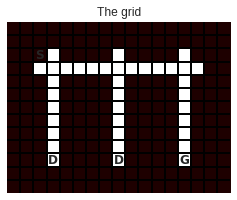

In [0]:
grid = Grid()
grid.plot_grid()


## Implement agents
**[10 pts]** In the next code cell, implement an agent that uses **tabular Sarsa** to learn action values.  The agent should act according to an $\epsilon$-greedy policy with respect to its action values.

The agent will be initialized with:
```
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              grid.get_obs())
```

In [0]:
class Sarsa(object):

  def __init__(self, number_of_states, number_of_actions, initial_state):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._action = 0
  
  def target_policy(self, q, a):
    return np.eye(len(q))[a]

  def behaviour_policy(self, q):
    return epsilon_greedy(q, 0.1)
  
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):   
    
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    action = self.behaviour_policy(self.q_values[next_s])        
    next_action = np.argmax(self.target_policy(self.q_values[next_s],action))    
    
    self.q_values[s, a] += 0.01*(r + g*(self.q_values[next_s,next_action]) - self.q_values[s, a])
    
    self._state = next_state 
    self._action = next_action
    return next_action


**[20 pts]** Implement an agent that uses **neural Sarsa** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

You are allowed, but not mandated, to use TensorFlow to implement this agent.  (The network is small enough that you can also use numpy, but then you have to implement your own backprop.)  Please document the code clearly, especially on non-trivial operations.

In [0]:
class NeuralSarsa():
  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, step_size=0.1):
    self._number_of_features = number_of_features
    self._s = initial_state
    self._number_of_hidden = number_of_hidden
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._size = int(number_of_features**0.5)
    self._last_action = 0

    with tf.device('/device:GPU:*'):
      tf.reset_default_graph()
    
      self.inputs = tf.placeholder("float", [None, self._size, self._size])
      self.targets = tf.placeholder("float", [None, 1])
      self.action = tf.placeholder("float", [None, 1])
      
      self.input_layer = tf.contrib.layers.flatten(self.inputs)
      
      self.weights1 = tf.Variable(tf.random_uniform([self._number_of_features, self._number_of_hidden], -0.05, 0.05))
      self.biases1 = tf.Variable(tf.zeros([self._number_of_hidden]))
      self.hidden_out = tf.nn.relu(tf.add(tf.matmul(tf.reshape(self.input_layer, [-1, self._number_of_features]), self.weights1), self.biases1))
      
      self.weights2 = tf.Variable(tf.random_uniform([self._number_of_hidden, self._number_of_actions], -0.05, 0.05))
      self.biases2 = tf.Variable(tf.zeros([self._number_of_actions]))
      self.logits = tf.add(tf.matmul(self.hidden_out, self.weights2),self.biases2)
      
      
      self.create_opt()
      self.init = tf.global_variables_initializer()
      self.sess = tf.Session()
      self.sess.run(self.init)

  def create_opt(self):
    self.indices = tf.concat([[[0]], tf.cast(self.action, tf.int32)], 1)
    self.aux = tf.gather_nd(self.logits, self.indices)
    self.diff = self.targets - self.aux
    self.q_loss = tf.square(self.diff)
    self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self._step_size).minimize(self.q_loss)
    
  def training(self, X, Y, a):
    self.sess.run([self.indices, 
                   self.aux, 
                   self.diff, 
                   self.q_loss, 
                   self.logits, 
                   self.optimizer],
                   feed_dict= {self.inputs: X,
                               self.targets: Y,
                               self.action: a})
    
  def target_policy(self, q, a):
    return np.eye(len(q))[a]

  def behaviour_policy(self, q):
    return epsilon_greedy(q, 0.1)
    
  def q(self, obs):
    obs = obs.reshape(-1, self._size, self._size) 
    q_values = self.sess.run(self.logits, feed_dict = {self.inputs: obs})
    return q_values[0]
  
  
  def step(self, r, g, s):
    
    q_update = self.q(s)
    next_a = np.argmax(self.target_policy(q_update,self.behaviour_policy(q_update)))    
    
    self.delta = (r + (g * q_update[next_a]) ).reshape(1,1)

    self.training(self._s.reshape(1, self._size, self._size), self.delta, np.array(self._last_action).reshape(1,1))
    
    self._s = s
    self._last_action = next_a
    
    return self._last_action

# Analyse Results

### Run the cells below to train the tabular and neural SARSA agents and to generate plots.

This trains the agents the Grid problem with an epsilon of 0.1.

The plots below will show action values for each of the actions, as well as a state value defined by $v(s) = \sum_a \pi(a|s) q(s, a)$.

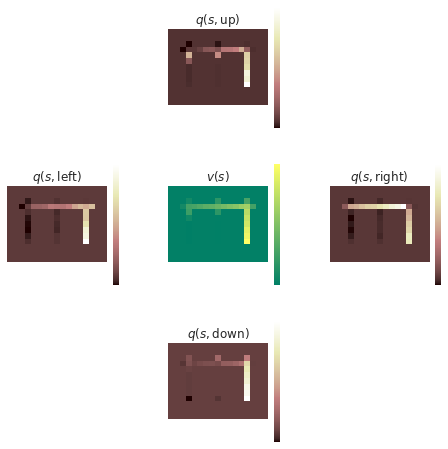

In [0]:
grid = Grid()
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              initial_state = grid.get_obs())
run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

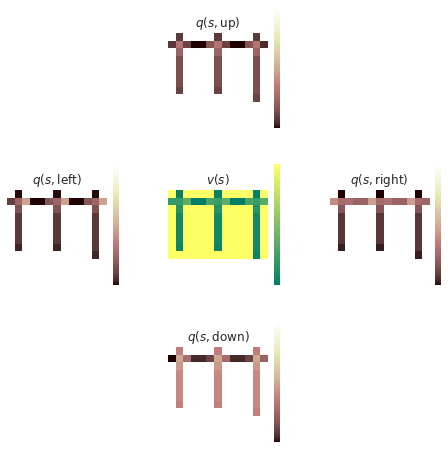

In [0]:
vision_size = 1
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape

obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

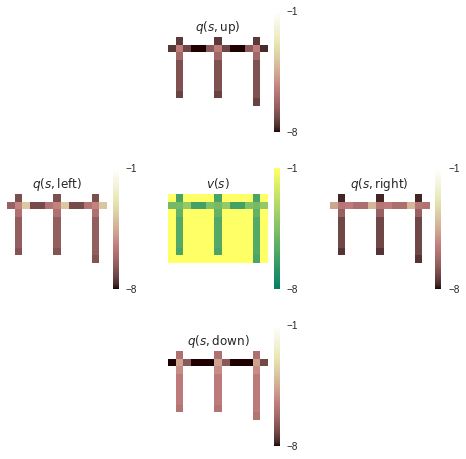

In [0]:
plot_action_values(qs,-8,-1)

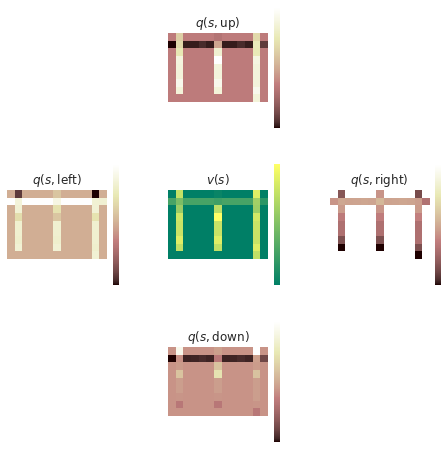

In [0]:
vision_size = 2
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

## Questions

Consider the greedy policy with respect to the estimated values

**[5 pts]** Which algorithm performed best?  Why?

Over 100,000 iterations the Tabular Sarsa performs better than the Neural Sarsa in terms of action values. However the Neural Sarsa is far better at 100,000 iterations compared with 10,000, this and the action values over time would suggest that in time Neural Sarsa would converge to optimal values along with Tabular Sarsa.

**[5 pts]** Is there a difference in the solution found by Neural Sarsa with a vision size of 1 (so 3x3 local observations), and a vision size of 2 (so 5x5 local observations)?  Why?

When plotting the action values of the two Neural Sarsa models, there is very little difference in performance, they both converge over time although this does not happen 100% of the time, when seeing the current plots we can see this. Both have negative action values after 100,000 iterations, both have sensible action values (for example, high action values right along the main hoizontal of the grid world) and both are converging. One big difference in the plots is that the extra vision allows model 2 to see differences in more of the grid around the main horizontal. This is shown by the sudden changes of action values in model 1 compared to model 2.

**[10 pts]** How could we improve the performance of the Neural Sarsa agent on this domain (for both vision sizes)?  Identify the main issue, and propose a concrete solution (in max 200 words).

The biggest issue is that the network forgets the previous states and the vision means that in many states it is unsure where it is on the gridworld. This is most apparent when plotting action values of the model 1, the crossroads on the grid have the same action value. This is because the model sees the same 4 squares and cannot differentiate between them. One big change could be a wider vision range with a deeper netowrk or perhaps a CNN. Another change could be a memory state of the previous 5-10 movements (perhaps concatenated together similar to video frames for atari), this would allow many states on the gridworld to differ, e.g. the furthest right crossroads is the most important as the network should go down from here, if the previous 10 actions have been "right" then this is a unique state in the gridworld and the model will hopefully increase the action value.

**[10 BONUS pts]** Implement your proposed improvement and show that it actually helps performance.